In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('data/train.csv')

In [3]:
test_df = pd.read_csv('data/test.csv')

In [4]:
Targets = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

In [5]:
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])

In [6]:
def create_datetime_features(df, *dt_attr, datetime_col='datetime'):
    '''This function creates date-time features from  datetime column in the DataFrame
        
        Args:
            df (pd.DataFrame): Pandas Dataframe with datetime Column
            dt_attr (args): args to take that can be used by datetime accessor
            datetime (str): Datetime Column Name  
        
        Returns:
            None: Adds New Columns that contain values created using datetime accessor 
    '''
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    for a in dt_attr:
        if a == 'week':
            df[a] = df[datetime_col].dt.isocalendar().week
            df[a] = df[a].astype(int)
        else:
            df[a] = getattr(df[datetime_col].dt, a)

In [7]:
datetime_features = ['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'week']

In [8]:
create_datetime_features(train_df, *datetime_features, datetime_col='Timestamp')

In [9]:
create_datetime_features(test_df, *datetime_features, datetime_col='Timestamp')

In [10]:
from sklearn.neural_network import MLPRegressor as MLPR

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_df.drop(['Timestamp']+Targets, axis=1))
x_inf_scaled = scaler.transform(test_df.drop(['Timestamp']+Targets, axis=1))

In [14]:
mlpr_dhi = MLPR(random_state=42, 
            solver='lbfgs',
            hidden_layer_sizes = (512, 128, 144, 48, 2), 
            max_iter=50, 
            validation_fraction=0.1, 
            learning_rate_init=0.02,
            verbose=True)
mlpr_dhi.fit(x_train_scaled, train_df.loc[:, Targets[0]])

c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=(512, 128, 144, 48, 2), learning_rate_init=0.02,
             max_iter=50, random_state=42, solver='lbfgs', verbose=True)

In [15]:
mean_squared_error(mlpr_dhi.predict(x_train_scaled), train_df.loc[:, Targets[0]])

964.2758150387052

In [17]:
y_mlpr_dhi = mlpr_dhi.predict(x_inf_scaled)

In [20]:
mlpr_dni = MLPR(random_state=42, 
            solver='lbfgs',
            hidden_layer_sizes = (512, 512, 128, 144, 48), 
            max_iter=20, 
            validation_fraction=0.1, 
            learning_rate_init=0.1, 
            verbose=True)
mlpr_dni.fit(x_train_scaled, train_df.loc[:, Targets[1]])

c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=(512, 512, 128, 144, 48),
             learning_rate_init=0.1, max_iter=20, random_state=42,
             solver='lbfgs', verbose=True)

In [21]:
mean_squared_error(mlpr_dni.predict(x_train_scaled), train_df.loc[:, Targets[1]])

6085.016119430259

In [223]:
y_mlpr_dni = mlpr_dni.predict(x_inf_scaled)

In [237]:
mlpr_ghi = MLPR(random_state=42, 
            solver='lbfgs',
            hidden_layer_sizes = (32, 24, 16, 8, 2), 
            max_iter=15, 
            validation_fraction=0.1, 
            learning_rate_init=0.02, 
            verbose=True)
mlpr_ghi.fit(x_train_scaled, train_df.loc[:, Targets[2]])

c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=(32, 24, 16, 8, 2), learning_rate_init=0.02,
             max_iter=15, random_state=42, solver='lbfgs', verbose=True)

In [238]:
mean_squared_error(mlpr_ghi.predict(x_train_scaled), train_df.loc[:, Targets[2]])

2099.9462269527567

In [227]:
y_mlpr_ghi = mlpr_ghi.predict(x_inf_scaled)

In [228]:
create_submission(y_mlpr_dhi, y_mlpr_dni, y_mlpr_ghi, 'submission_mlpr_new3.csv')

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

In [23]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [24]:
train_df.minute.unique()

array([ 0, 10, 20, 30, 40, 50], dtype=int64)

In [25]:
def create_trig_features(df):
    df["hour_sin"] = sin_transformer(24).fit_transform(df[["hour"]])["hour"]
    df["hour_cos"] = cos_transformer(24).fit_transform(df[["hour"]])["hour"]

    df["minute_sin"] = sin_transformer(60).fit_transform(df[["minute"]])["minute"]
    df["minute_cos"] = cos_transformer(60).fit_transform(df[["minute"]])["minute"]

    df["month_sin"] = sin_transformer(12).fit_transform(df[["month"]])["month"]
    df["month_cos"] = cos_transformer(12).fit_transform(df[["month"]])["month"]

    df["week_sin"] = sin_transformer(53).fit_transform(df[["week"]])["week"]
    df["week_cos"] = cos_transformer(53).fit_transform(df[["week"]])["week"]

    df["doy_sin"] = sin_transformer(53).fit_transform(df[["day_of_year"]])["day_of_year"]
    df["doy_cos"] = cos_transformer(53).fit_transform(df[["day_of_year"]])["day_of_year"]

In [26]:
create_trig_features(train_df)

In [27]:
def create_ohe_datetime_features(df, datetime_cols_list = ['minute', 'hour', 'month', 'day', 'day_of_week']):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    ohe_dt_transformer = ColumnTransformer(transformers=[('ohe_datetime', ohe, 
                                                         datetime_cols_list
                                                        )
                                                        ]
                                        )
    ohe_dt_transformer.set_output(transform='pandas')
    ohe_df = ohe_dt_transformer.fit_transform(df)
    ohe_df = ohe_df.astype('int')
    df = df.join(ohe_df)
    return df

In [28]:
train_df = create_ohe_datetime_features(train_df)

In [29]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    '''
    Calculates Mutual Information Score for a given Target variable and List of Features
    
    Args:
        X: DataFrame of Features
        y: Array or Dataframe consisting of Target Variables
    Returns:
        MI Score
    '''
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values()
    return mi_scores

In [30]:
test_df[['Wind Direction', 'Fill Flag', 'Cloud Type']] = test_df[['Wind Direction', 'Fill Flag', 'Cloud Type']].astype('int32')
train_df[['Wind Direction', 'Fill Flag', 'Cloud Type']] = train_df[['Wind Direction', 'Fill Flag', 'Cloud Type']].astype('int32')


In [31]:
def gen_mi_score(df, Target, Targets=Targets):
    discrete_features = train_df.drop(Targets+['Timestamp'], axis=1).dtypes == 'int32'
    mi_score = make_mi_scores(df.drop(Targets+['Timestamp'], axis=1), df[Target], discrete_features)
    return mi_score

<Axes: xlabel='Timestamp'>

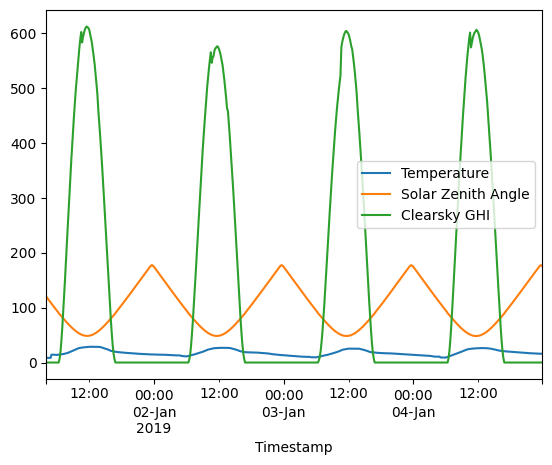

In [32]:
train_df.set_index('Timestamp')[['Temperature', 'Solar Zenith Angle', Targets[2]]].iloc[24:96*6].plot()

In [33]:
train_df['Temperature_rolling'] = train_df['Temperature'].rolling(24*4, center=True).mean()
train_df['sza_hour'] = train_df['Solar Zenith Angle']*(-(train_df['hour_cos']))
train_df['sza_hour_cos'] = train_df['Solar Zenith Angle']*train_df['hour_cos']
train_df['sza_hour_sin'] = train_df['Solar Zenith Angle']*train_df['hour_sin']

<Axes: xlabel='Timestamp'>

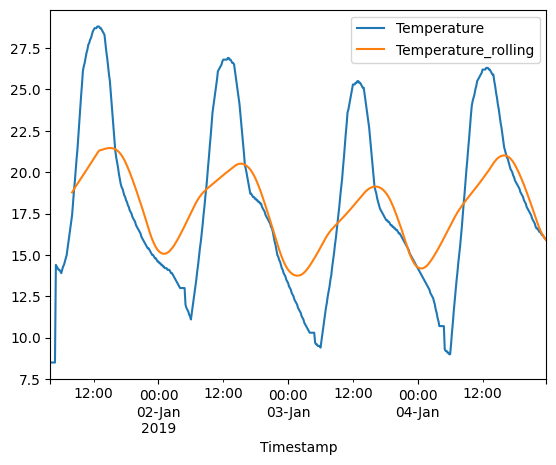

In [34]:
train_df.set_index('Timestamp')[['Temperature', 'Temperature_rolling']].iloc[24:96*6].plot()

<Axes: xlabel='Timestamp'>

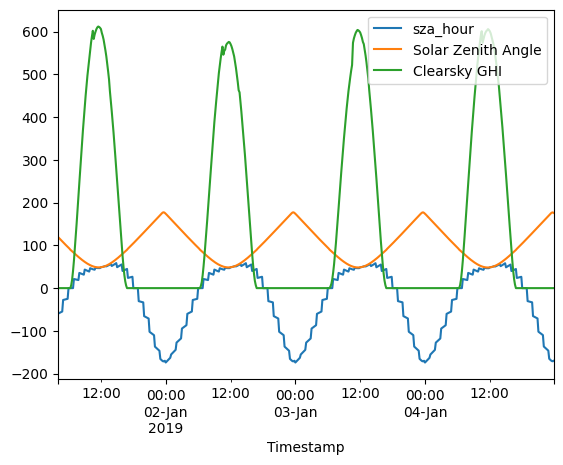

In [35]:
train_df.set_index('Timestamp')[['sza_hour', 'Solar Zenith Angle', Targets[2]]].iloc[24:96*6].plot()

In [36]:
mi_score_dhi = gen_mi_score(train_df.dropna(), 'Clearsky DHI')

<Axes: >

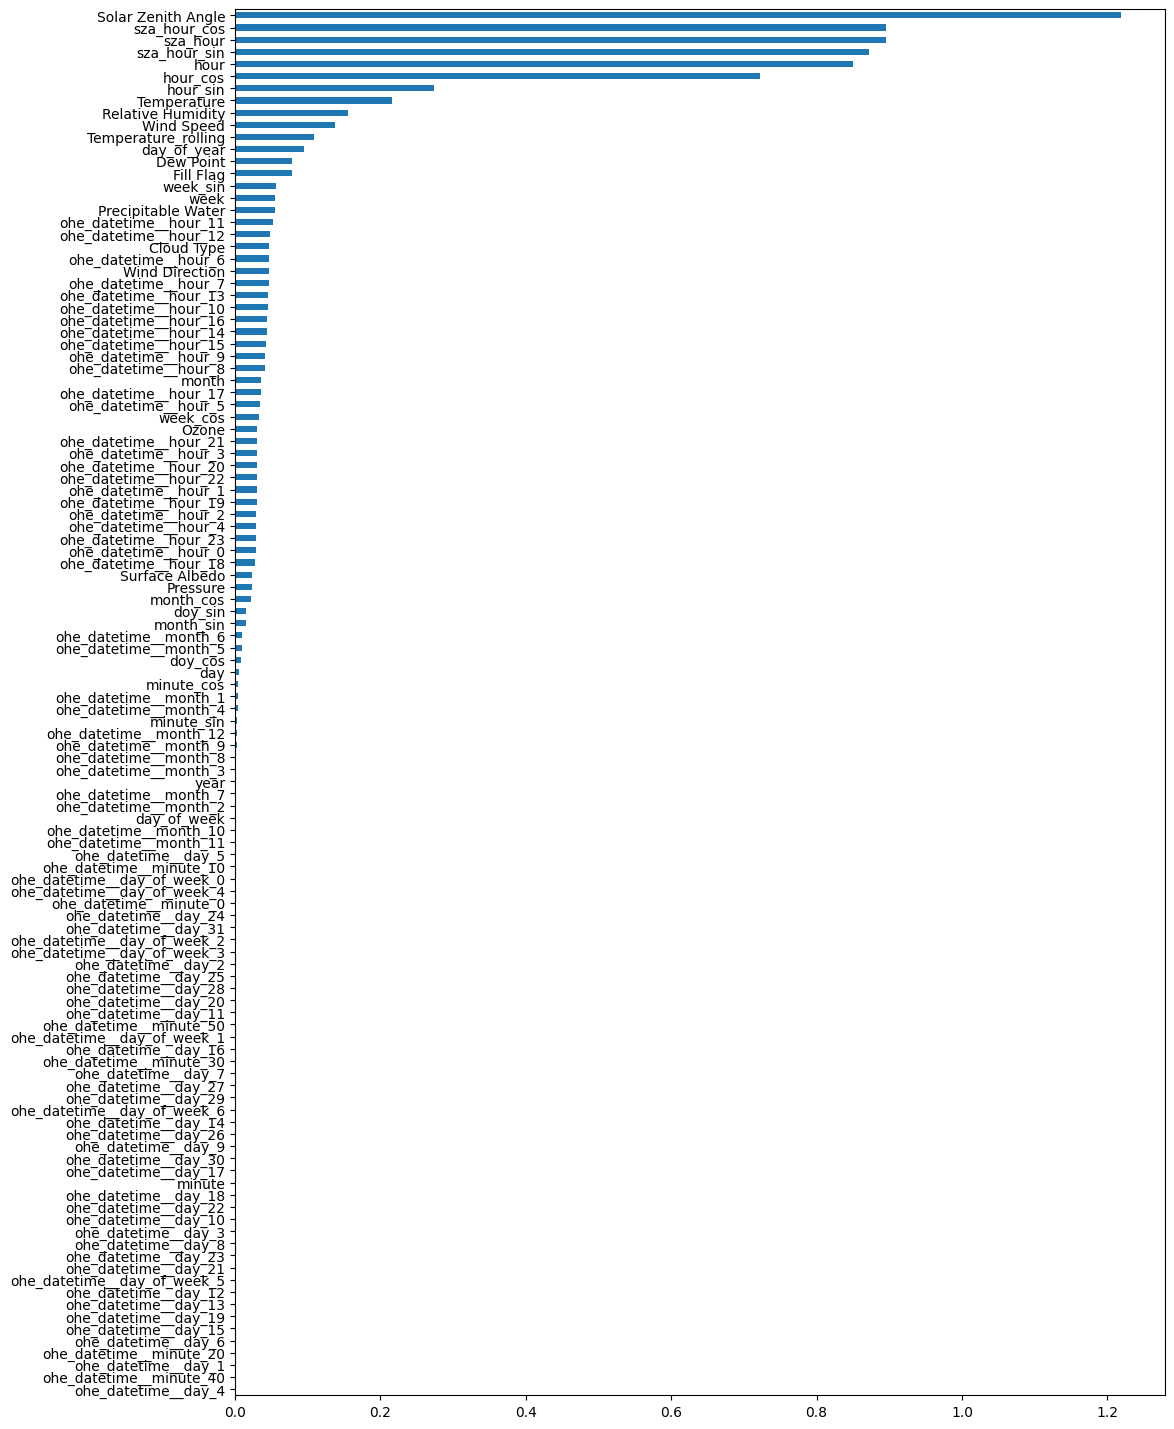

In [37]:
mi_score_dhi.plot.barh(figsize=(12,18))

In [38]:
mi_score_dni = gen_mi_score(train_df.dropna(), 'Clearsky DNI')

<Axes: >

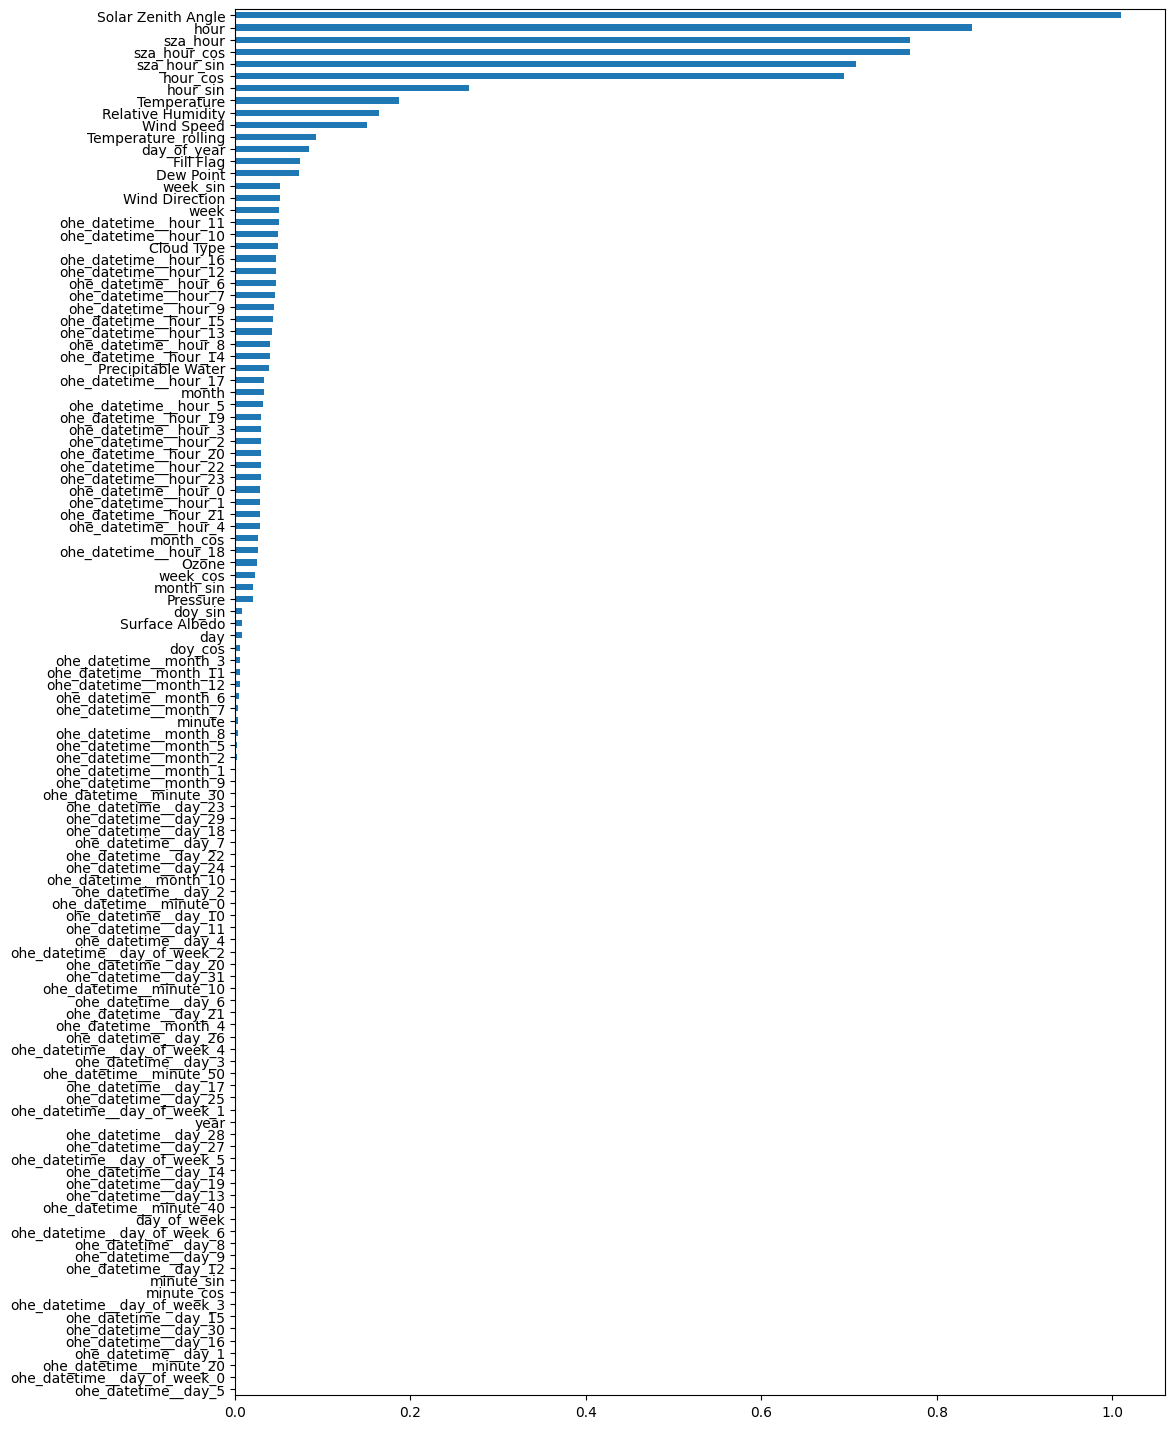

In [39]:
mi_score_dni.plot.barh(figsize=(12,18))

In [40]:
mi_score_ghi = gen_mi_score(train_df.dropna(), 'Clearsky GHI')

<Axes: >

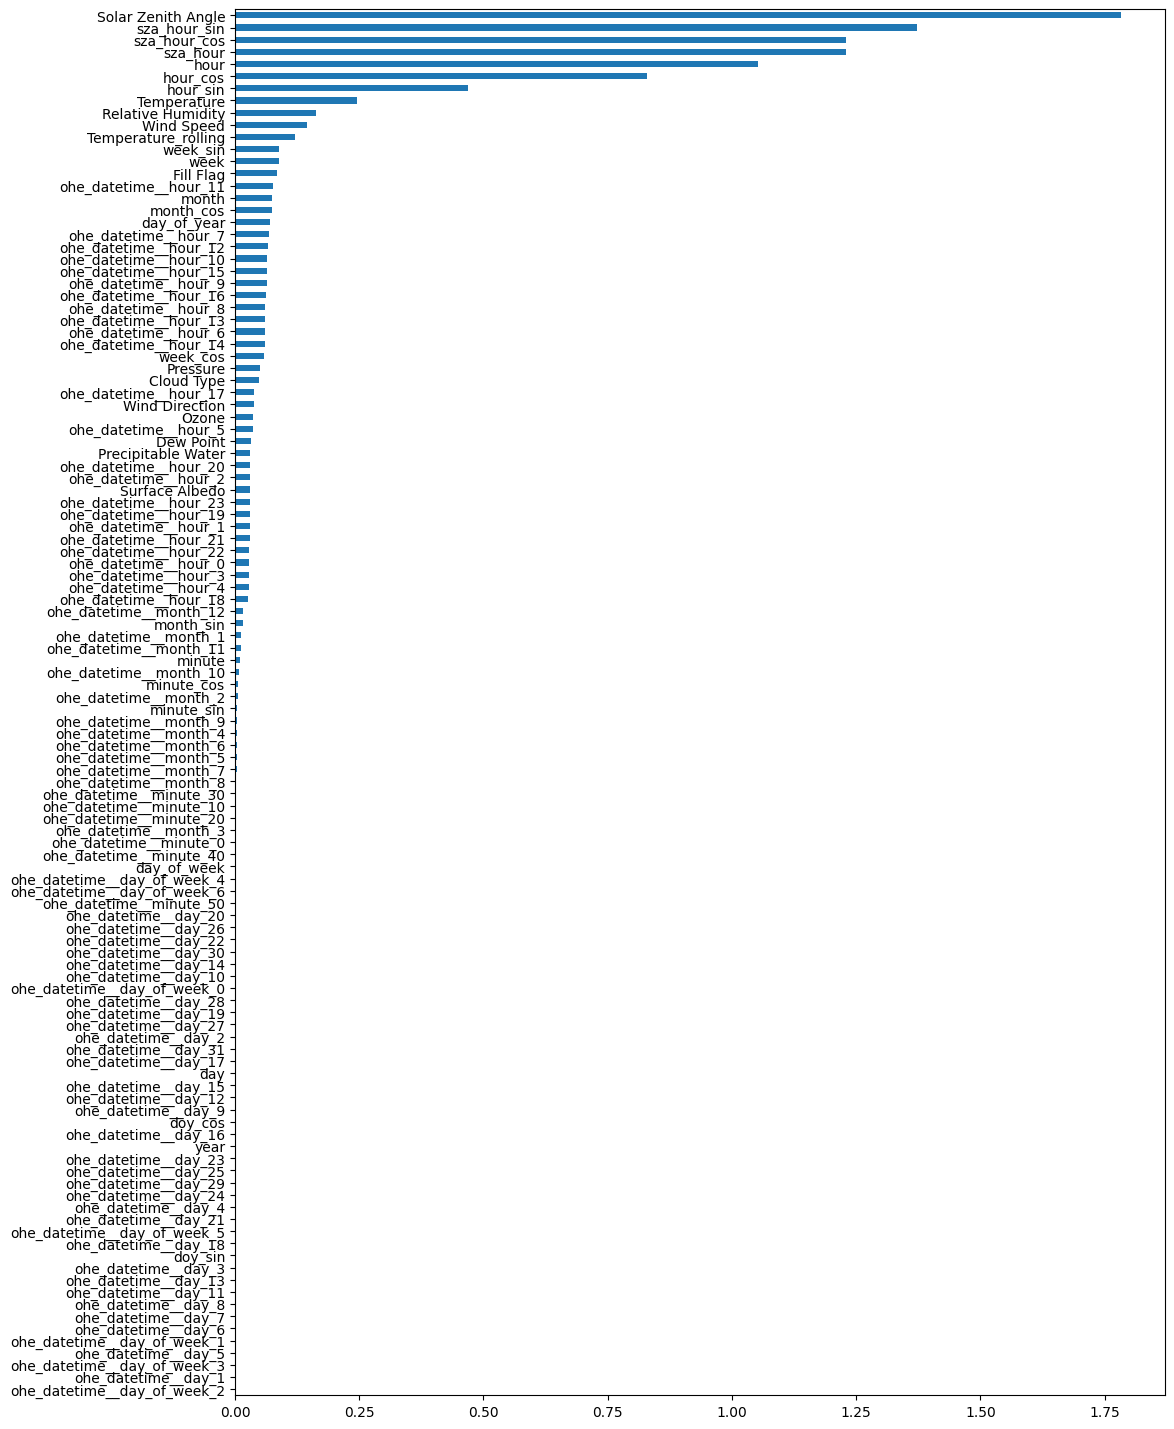

In [41]:
mi_score_ghi.plot.barh(figsize=(12,18))

In [42]:
# train_df.reset_index(inplace=True)
# test_df.reset_index(inplace=True)

In [43]:
train_df['Cloud Type'] = train_df['Cloud Type'].astype('category')

In [44]:
train_df.set_index('Timestamp', inplace=True)
y = train_df[Targets]
X = train_df.drop(Targets, axis=1)

In [45]:
# create_datetime_features(test_df, *datetime_features, datetime_col='Timestamp')
create_trig_features(test_df)
test_df = create_ohe_datetime_features(test_df)

In [46]:
test_df['Temperature_rolling'] = test_df['Temperature'].rolling(24*4, center=True).mean()
test_df['sza_hour'] = test_df['Solar Zenith Angle']*(-(test_df['hour_cos']))
test_df['sza_hour_cos'] = test_df['Solar Zenith Angle']*test_df['hour_cos']
test_df['sza_hour_sin'] = test_df['Solar Zenith Angle']*test_df['hour_sin']

In [47]:
# test_df['Fill Flag'].replace({3:1, 5:1}, inplace=True)

In [48]:
from lightgbm import plot_importance

In [49]:
test_df['Cloud Type'] = test_df['Cloud Type'].astype('category')

In [50]:
test_df.set_index('Timestamp', inplace=True)
y_targets = test_df[Targets]
X_inf = test_df.drop(Targets, axis=1)

In [51]:
imp_threshold = 0.003
imp_cols = list(set(mi_score_dhi[mi_score_dhi>imp_threshold].index)|set(mi_score_dni[mi_score_dni>imp_threshold].index)|set(mi_score_ghi[mi_score_ghi>imp_threshold].index))

In [52]:
# X = train_df[imp_cols]
# X_inf = test_df[imp_cols]

X = X
X_inf = X_inf

In [80]:
from sklearn.kernel_approximation import Nystroem

In [100]:
nystroem = Nystroem(kernel='rbf', n_components=100)

In [101]:
weather_features = ['Temperature', 'Dew Point', 'Surface Albedo', 'Pressure', 'Wind Direction', 'Wind Speed', 'Ozone', 'Cloud Type', 'Solar Zenith Angle']

In [102]:
nystroem.set_output(transform='pandas')

Nystroem()

In [103]:
new_features = nystroem.fit_transform(X[weather_features])

In [104]:
X_new = X.join(new_features)

In [105]:
new_features_inf = nystroem.transform(X_inf[weather_features])
X_inf_new = X_inf.join(new_features_inf)

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

In [141]:
def create_submission(y_dhi, y_dni, y_ghi, file_name):
    submission_file = pd.read_csv('data/submission.csv')
    submission_file.iloc[:, 0] = pd.Series(np.round(y_dhi, 3)).apply(lambda x: 0 if (x<0) else x)
    submission_file.iloc[:, 1] = pd.Series(np.round(y_dni, 3)).apply(lambda x: 0 if (x<0) else x)
    submission_file.iloc[:, 2] = pd.Series(np.round(y_ghi, 3)).apply(lambda x: 0 if (x<0) else x)
    submission_file.to_csv(file_name, index=False)

In [55]:
from lightgbm import LGBMRegressor

In [56]:
from lightgbm import early_stopping

In [57]:
from optuna.integration import lightgbm as lgb

c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
def optuna_tune_lgb(train_x, val_x, train_y, val_y):
    params = {
        "objective": "mse",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)
    best_params, tuning_history = dict(), list()
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100)],
    )
    
    prediction =model.predict(val_x, num_iteration=model.best_iteration)
    accuracy = mean_squared_error(val_y, prediction)
    best_params = model.params

    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

    return model

In [211]:
regr_dhi = MLPR(random_state=42,
            solver='lbfgs', 
            hidden_layer_sizes = (64, 32, 16, 8, 2), 
            max_iter=10, 
            validation_fraction=0.1, 
            learning_rate_init=0.02, 
            verbose=True)
regr_dhi.fit(X.dropna(axis=1), y.iloc[:, 0])
y_regr_dhi = regr_dhi.predict(X_inf.dropna(axis=1))

In [212]:
mean_squared_error(regr_dhi.predict(X.dropna(axis=1)), y.iloc[:, 0])

14480.29410805966

In [160]:
regr_dni = MLPR(random_state=42,
            # solver='lbfgs',
            hidden_layer_sizes = (1024, 512, 512, 144, 144), 
            max_iter=25, 
            validation_fraction=0.25, 
            learning_rate_init=0.01, 
            verbose=True)
regr_dni.fit(X_new.dropna(axis=1), y.iloc[:, 1])
y_regr_dni = regr_dni.predict(X_inf_new.dropna(axis=1))

Iteration 1, loss = 31521.72554207
Iteration 2, loss = 2404.90935653
Iteration 3, loss = 2311.82458894
Iteration 4, loss = 2139.51701086
Iteration 5, loss = 2151.67468300
Iteration 6, loss = 2089.90636961
Iteration 7, loss = 2032.47474276
Iteration 8, loss = 2012.34242321
Iteration 9, loss = 1997.49244838
Iteration 10, loss = 2016.93334399
Iteration 11, loss = 1894.08226755
Iteration 12, loss = 1916.42518207
Iteration 13, loss = 1846.50607097
Iteration 14, loss = 1822.38960296
Iteration 15, loss = 1809.90214122
Iteration 16, loss = 1763.30844330
Iteration 17, loss = 1724.64971464
Iteration 18, loss = 1713.29876226
Iteration 19, loss = 1685.07725136
Iteration 20, loss = 1661.38021734
Iteration 21, loss = 1668.06297917
Iteration 22, loss = 1620.41648450
Iteration 23, loss = 1605.81661962
Iteration 24, loss = 1584.22691626
Iteration 25, loss = 1595.75731926


c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [161]:
mean_squared_error(regr_dni.predict(X_new.dropna(axis=1)), y.iloc[:, 1])

2882.02935187222

In [153]:
regr_ghi = MLPR(random_state=42, 
            hidden_layer_sizes = (64, 32, 16, 8, 2), 
            max_iter=10, 
            validation_fraction=0.1, 
            learning_rate_init=0.02, 
            verbose=True)
regr_ghi.fit(X.dropna(axis=1), y.iloc[:, 2])
y_regr_ghi = regr_ghi.predict(X_inf.dropna(axis=1))

Iteration 1, loss = 81832.50647751
Iteration 2, loss = 77158.18633320
Iteration 3, loss = 73010.31553341
Iteration 4, loss = 69325.98982036
Iteration 5, loss = 66064.53796908
Iteration 6, loss = 63205.47002266
Iteration 7, loss = 60734.00411839
Iteration 8, loss = 58644.60097625
Iteration 9, loss = 56915.56029631
Iteration 10, loss = 55540.13991855


c:\ProgramData\Miniconda3\envs\Azure\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [156]:
create_submission(y_regr_dhi, y_regr_dni, y_regr_ghi, 'submission_mlp_new1.csv')

In [106]:
# booster1 = optuna_tune_lgb(x_train, x_val, y_train.iloc[:, 0], y_val.iloc[:, 0])

In [136]:
light_model_dhi = LGBMRegressor(
                                # objective='poisson',
                                # **booster1.params
                                )
light_model_dhi.fit(X_new, y.iloc[:, 0])
y_light_dhi = light_model_dhi.predict(X_inf_new)

In [137]:
mean_squared_error(light_model_dhi.predict(X_new), y.iloc[:, 0])

356.5156090936486

In [93]:
y.iloc[:, 1].name

'Clearsky DNI'

In [94]:
# booster2 = optuna_tune_lgb(x_train, x_val, y_train.iloc[:, 1], y_val.iloc[:, 1])

In [133]:
light_model_dni = LGBMRegressor(
                                # objective='poisson',
                                # **booster2.params
                                )

light_model_dni.fit(X_new, y.iloc[:, 1])
y_light_dni = light_model_dni.predict(X_inf_new)

In [134]:
mean_squared_error(light_model_dni.predict(X_new), y.iloc[:, 1])

1789.6967701193303

In [63]:
y.iloc[:, 2].name

'Clearsky GHI'

In [64]:
# booster3 = optuna_tune_lgb(x_train, x_val, y_train.iloc[:, 2], y_val.iloc[:, 2])

In [138]:
light_model_ghi = LGBMRegressor(
                                # objective='poisson',
                                # **booster3.params
                                )
light_model_ghi.fit(X_new, y.iloc[:, 2])
y_light_ghi = light_model_ghi.predict(X_inf_new)

In [139]:
mean_squared_error(light_model_ghi.predict(X_new), y.iloc[:, 2])

85.95745774567062

In [66]:
Targets

['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

In [142]:
create_submission(y_light_dhi, y_light_dni, y_light_ghi, 'submission_lgb_new9.csv')

In [134]:
file_name = 'submission_lgb_new8.csv'
y_dhi, y_dni, y_ghi = y_light_dhi, y_light_dni, y_light_ghi
submission_file = pd.read_csv('submission.csv')
submission_file.iloc[:, 0] = pd.Series(np.round(y_dhi, 3)).apply(lambda x: 0 if (x<0) else x)
submission_file.iloc[:, 1] = pd.Series(np.round(y_dni, 3)).apply(lambda x: 0 if (x<0) else x)
submission_file.iloc[:, 2] = pd.Series(np.round(y_ghi, 3)).apply(lambda x: 0 if (x<0) else x)
submission_file.to_csv(file_name, index=False)

In [116]:
from xgboost import XGBRegressor

In [117]:
Targets

['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

In [119]:
X_new['Cloud Type'] = X_new['Cloud Type'].astype(int)

In [120]:
xgb_model_dhi = XGBRegressor()
xgb_model_dhi.fit(X_new, y[Targets[0]])

xgb_model_dni = XGBRegressor()
xgb_model_dni.fit(X_new, y[Targets[1]])

xgb_model_ghi = XGBRegressor()
xgb_model_ghi.fit(X_new, y[Targets[2]])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [123]:
X_inf_new['Cloud Type'] = X_inf_new['Cloud Type'].astype(int)

In [124]:
y_xgb_dhi = np.round(xgb_model_dhi.predict(X_inf_new),2)
y_xgb_dni = np.round(xgb_model_dni.predict(X_inf_new),2)
y_xgb_ghi = np.round(xgb_model_ghi.predict(X_inf_new),2)

In [126]:
mean_squared_error(xgb_model_dhi.predict(X_new), y.iloc[:, 0])

204.4301277233227

In [125]:
mean_squared_error(xgb_model_dni.predict(X_new), y.iloc[:, 1])

1017.2977121079726

In [127]:
mean_squared_error(xgb_model_ghi.predict(X_new), y.iloc[:, 2])

48.27513957491819

In [143]:
create_submission(y_xgb_dhi, y_xgb_dni, y_xgb_ghi, 'submission_xgb_new4.csv')

In [240]:
from lightgbm import LGBMRegressor

In [250]:
light_model = LGBMRegressor(objective='mse')
light_model_dhi.fit(X, train_df_targets.iloc[:, 0])
y_light_dhi = light_model_dhi.predict(X_inf)

In [124]:
train_df_targets.iloc[:, 0].name

'Clearsky DHI'

In [126]:
train_df_targets.iloc[:, 1].name

'Clearsky DNI'

In [251]:
light_model_dni = LGBMRegressor(objective='mse')
light_model_dni.fit(X, train_df_targets.iloc[:, 1])
y_light_dni = light_model_dni.predict(X_inf)

In [128]:
train_df_targets.iloc[:, 2].name

'Clearsky GHI'

In [252]:
light_model_ghi = LGBMRegressor(objective='mse')
light_model_ghi.fit(X, train_df_targets.iloc[:, 2])
y_light_ghi = light_model_ghi.predict(X_inf)

In [130]:
Targets

['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

In [253]:
create_submission(y_light_dhi, y_light_dni, y_light_ghi, 'submission_lgb2.csv')

In [131]:
submission_df = pd.DataFrame({k:v for k,v in zip(Targets, [y_light_dhi,y_light_dni,y_light_ghi])})

<Axes: >

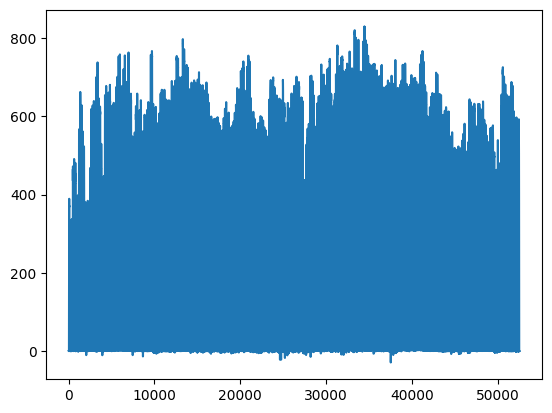

In [132]:
submission_df['Clearsky DNI'].plot()

In [133]:
train_df_targets[Targets[0]].max()

603

In [134]:
submission_df = submission_df.applymap(lambda x: 0 if (x<1) else x)

In [135]:
submission_df.shape

(52560, 3)

In [136]:
submission_df.to_csv('results/submission6.csv', index=False)

In [137]:
submission_file = pd.read_csv('submission.csv')

submission_file.iloc[:, 0] = pd.Series(y_light_dhi).apply(lambda x: 0 if (x<1) else x)
submission_file.iloc[:, 1] = pd.Series(y_light_dni).apply(lambda x: 0 if (x<1) else x)
submission_file.iloc[:, 2] = pd.Series(y_light_ghi).apply(lambda x: 0 if (x<1) else x)

submission_file.to_csv('submission6.csv', index=False)